<h1>Classification</h1>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


<h2 align="center">Random Forests</h2><h3>Parameters study</h3>

In [1]:
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart


file_tag = "stroke"
train_filename = "./../../../data/class_covid_final_train.csv"
test_filename = "./../../../data/class_covid_final_test.csv"
target = "CovidPos"
eval_metric = "accuracy"

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)
#trnX = trnX[:100]
#tstX = tstX[:100]
#trnY = trnY[:100]
#tstY = tstY[:100]
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=266652 Test#=114280
Labels=[0. 1.]


In [2]:
import numpy as np
from sklearn.model_selection import PredefinedSplit

fullX = np.concatenate([trnX, tstX])
fullY = np.concatenate([trnY, tstY])
test_fold = [-1] * len(trnX) + [0] * len(tstX)
cv = PredefinedSplit(test_fold)
for i, (train_index, test_index) in enumerate(cv.split()):
    print(f"Fold {i}")
    print(f"  Train: {len(train_index)=}")
    print(f"  Test: {len(test_index)=}")

Fold 0
  Train: len(train_index)=266652
  Test: len(test_index)=114280


In [6]:
nr_max_trees = 2500
lag = 500
n_estimators = list(range(1, nr_max_trees + 1, lag))
max_depths = [2, 5, 7]
max_features = [0.1, 0.3, 0.5, 0.7, 0.9]

param_grid = {
    "n_estimators": n_estimators,
    "max_depth": max_depths,
    "max_features": max_features
}
print(param_grid)

clf = RandomForestClassifier(n_jobs=2, verbose=1)
search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="accuracy", cv=cv, verbose=10, return_train_score=True, n_jobs=2)
search.fit(fullX, fullY)

{'n_estimators': [1, 501, 1001, 1501, 2001], 'max_depth': [2, 5, 7], 'max_features': [0.1, 0.3, 0.5, 0.7, 0.9]}
Fitting 1 folds for each of 75 candidates, totalling 75 fits
[CV 1/1; 1/75] START max_depth=2, max_features=0.1, n_estimators=1..............
[CV 1/1; 2/75] START max_depth=2, max_features=0.1, n_estimators=501............


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


[CV 1/1; 1/75] END max_depth=2, max_features=0.1, n_estimators=1;, score=(train=0.709, test=0.709) total time=   0.2s
[CV 1/1; 3/75] START max_depth=2, max_features=0.1, n_estimators=1001...........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   11.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   11.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   25.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   26.1s
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:   28.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:    2.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(

[CV 1/1; 2/75] END max_depth=2, max_features=0.1, n_estimators=501;, score=(train=0.709, test=0.709) total time=  31.2s
[CV 1/1; 4/75] START max_depth=2, max_features=0.1, n_estimators=1501...........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:   46.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   12.7s
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:   58.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   26.5s
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:    4.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.8s
[Paral

[CV 1/1; 3/75] END max_depth=2, max_features=0.1, n_estimators=1001;, score=(train=0.709, test=0.709) total time= 1.1min
[CV 1/1; 5/75] START max_depth=2, max_features=0.1, n_estimators=2001...........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:   45.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   11.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   25.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:   44.3s
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:  1.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    5.3s
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:    6.4s finished
[Parallel(n_jobs=2)]: U

[CV 1/1; 4/75] END max_depth=2, max_features=0.1, n_estimators=1501;, score=(train=0.709, test=0.709) total time= 1.5min
[CV 1/1; 6/75] START max_depth=2, max_features=0.3, n_estimators=1..............
[CV 1/1; 6/75] END max_depth=2, max_features=0.3, n_estimators=1;, score=(train=0.709, test=0.709) total time=   0.4s
[CV 1/1; 7/75] START max_depth=2, max_features=0.3, n_estimators=501............


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   21.4s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:  1.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    5.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   48.8s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    7.5s
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:    8.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Pa

[CV 1/1; 7/75] END max_depth=2, max_features=0.3, n_estimators=501;, score=(train=0.709, test=0.709) total time=  56.7s
[CV 1/1; 8/75] START max_depth=2, max_features=0.3, n_estimators=1001...........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:   15.2s
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:   16.9s finished


[CV 1/1; 5/75] END max_depth=2, max_features=0.1, n_estimators=2001;, score=(train=0.709, test=0.709) total time= 2.0min
[CV 1/1; 9/75] START max_depth=2, max_features=0.3, n_estimators=1501...........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   17.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   18.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   40.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   41.5s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:  1.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:    3.8s finished
[Parallel(n_jobs=2)]: Usi

[CV 1/1; 8/75] END max_depth=2, max_features=0.3, n_estimators=1001;, score=(train=0.709, test=0.709) total time= 1.7min
[CV 1/1; 10/75] START max_depth=2, max_features=0.3, n_estimators=2001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   19.7s
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:  2.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   41.5s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:    5.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Par

[CV 1/1; 9/75] END max_depth=2, max_features=0.3, n_estimators=1501;, score=(train=0.709, test=0.709) total time= 2.5min
[CV 1/1; 11/75] START max_depth=2, max_features=0.5, n_estimators=1.............
[CV 1/1; 11/75] END max_depth=2, max_features=0.5, n_estimators=1;, score=(train=0.709, test=0.709) total time=   0.4s
[CV 1/1; 12/75] START max_depth=2, max_features=0.5, n_estimators=501...........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.9s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   24.6s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   55.7s
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.7s
[Parallel

[CV 1/1; 12/75] END max_depth=2, max_features=0.5, n_estimators=501;, score=(train=0.709, test=0.709) total time= 1.1min
[CV 1/1; 13/75] START max_depth=2, max_features=0.5, n_estimators=1001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   24.4s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:  2.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    6.6s
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:    7.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Pa

[CV 1/1; 10/75] END max_depth=2, max_features=0.3, n_estimators=2001;, score=(train=0.709, test=0.709) total time= 3.0min
[CV 1/1; 14/75] START max_depth=2, max_features=0.5, n_estimators=1501..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   28.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:    4.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.8s
[Paral

[CV 1/1; 13/75] END max_depth=2, max_features=0.5, n_estimators=1001;, score=(train=0.709, test=0.709) total time= 2.3min
[CV 1/1; 15/75] START max_depth=2, max_features=0.5, n_estimators=2001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   28.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:  3.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:    6.1s finished
[Parallel(n_jobs=2)]: U

[CV 1/1; 14/75] END max_depth=2, max_features=0.5, n_estimators=1501;, score=(train=0.709, test=0.709) total time= 3.7min
[CV 1/1; 16/75] START max_depth=2, max_features=0.7, n_estimators=1.............
[CV 1/1; 16/75] END max_depth=2, max_features=0.7, n_estimators=1;, score=(train=0.709, test=0.709) total time=   0.5s
[CV 1/1; 17/75] START max_depth=2, max_features=0.7, n_estimators=501...........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.6s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   35.8s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:  1.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:    1.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.7s
[Paralle

[CV 1/1; 17/75] END max_depth=2, max_features=0.7, n_estimators=501;, score=(train=0.709, test=0.709) total time= 1.6min
[CV 1/1; 18/75] START max_depth=2, max_features=0.7, n_estimators=1001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.2s
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:  4.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    7.1s
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:    7.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    3.9s
[Par

[CV 1/1; 15/75] END max_depth=2, max_features=0.5, n_estimators=2001;, score=(train=0.709, test=0.709) total time= 4.8min
[CV 1/1; 19/75] START max_depth=2, max_features=0.7, n_estimators=1501..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   34.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:  2.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:    3.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Paral

[CV 1/1; 18/75] END max_depth=2, max_features=0.7, n_estimators=1001;, score=(train=0.709, test=0.709) total time= 2.9min
[CV 1/1; 20/75] START max_depth=2, max_features=0.7, n_estimators=2001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   33.9s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:  4.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:    5.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Par

[CV 1/1; 19/75] END max_depth=2, max_features=0.7, n_estimators=1501;, score=(train=0.709, test=0.709) total time= 4.4min
[CV 1/1; 21/75] START max_depth=2, max_features=0.9, n_estimators=1.............
[CV 1/1; 21/75] END max_depth=2, max_features=0.9, n_estimators=1;, score=(train=0.709, test=0.709) total time=   0.5s
[CV 1/1; 22/75] START max_depth=2, max_features=0.9, n_estimators=501...........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   41.7s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:  1.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    3.9s
[Parallel

[CV 1/1; 22/75] END max_depth=2, max_features=0.9, n_estimators=501;, score=(train=0.709, test=0.709) total time= 1.8min
[CV 1/1; 23/75] START max_depth=2, max_features=0.9, n_estimators=1001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   41.8s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:  5.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    6.9s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:    7.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Pa

[CV 1/1; 20/75] END max_depth=2, max_features=0.7, n_estimators=2001;, score=(train=0.709, test=0.709) total time= 5.8min
[CV 1/1; 24/75] START max_depth=2, max_features=0.9, n_estimators=1501..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   42.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:  3.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:    3.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.7s
[Paral

[CV 1/1; 23/75] END max_depth=2, max_features=0.9, n_estimators=1001;, score=(train=0.709, test=0.709) total time= 3.6min
[CV 1/1; 25/75] START max_depth=2, max_features=0.9, n_estimators=2001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   42.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:  5.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:    5.8s finished
[Parallel(n_jobs=2)]: U

[CV 1/1; 24/75] END max_depth=2, max_features=0.9, n_estimators=1501;, score=(train=0.709, test=0.709) total time= 5.4min
[CV 1/1; 26/75] START max_depth=5, max_features=0.1, n_estimators=1.............
[CV 1/1; 26/75] END max_depth=5, max_features=0.1, n_estimators=1;, score=(train=0.709, test=0.709) total time=   0.3s
[CV 1/1; 27/75] START max_depth=5, max_features=0.1, n_estimators=501...........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   14.9s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   34.4s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:   39.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:    2.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    5.4s
[Parallel

[CV 1/1; 27/75] END max_depth=5, max_features=0.1, n_estimators=501;, score=(train=0.709, test=0.709) total time=  42.4s
[CV 1/1; 28/75] START max_depth=5, max_features=0.1, n_estimators=1001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   20.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   47.9s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:  1.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:    5.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.5s
[Paral

[CV 1/1; 28/75] END max_depth=5, max_features=0.1, n_estimators=1001;, score=(train=0.709, test=0.709) total time= 1.9min
[CV 1/1; 29/75] START max_depth=5, max_features=0.1, n_estimators=1501..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  6.9min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   19.9s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   46.9s
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:  7.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    5.5s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    8.1s
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:    9.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Pa

[CV 1/1; 25/75] END max_depth=2, max_features=0.9, n_estimators=2001;, score=(train=0.709, test=0.709) total time= 8.1min
[CV 1/1; 30/75] START max_depth=5, max_features=0.1, n_estimators=2001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   20.3s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   44.4s
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:  2.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    4.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    6.5s
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:    7.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Par

[CV 1/1; 29/75] END max_depth=5, max_features=0.1, n_estimators=1501;, score=(train=0.709, test=0.709) total time= 2.8min
[CV 1/1; 31/75] START max_depth=5, max_features=0.3, n_estimators=1.............
[CV 1/1; 31/75] END max_depth=5, max_features=0.3, n_estimators=1;, score=(train=0.709, test=0.709) total time=   0.5s
[CV 1/1; 32/75] START max_depth=5, max_features=0.3, n_estimators=501...........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.0s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   37.6s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:  1.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:  3.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 

[CV 1/1; 32/75] END max_depth=5, max_features=0.3, n_estimators=501;, score=(train=0.709, test=0.709) total time= 1.6min
[CV 1/1; 33/75] START max_depth=5, max_features=0.3, n_estimators=1001..........


[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    6.5s
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    9.6s
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:   10.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    5.5s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    9.5s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:   14.8s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:   21.4s
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:   23.8s finished


[CV 1/1; 30/75] END max_depth=5, max_features=0.1, n_estimators=2001;, score=(train=0.709, test=0.709) total time= 3.2min
[CV 1/1; 34/75] START max_depth=5, max_features=0.3, n_estimators=1501..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   38.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   40.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:  3.2min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:    5.5s finished
[Parallel(n_jobs=2)]: Usi

[CV 1/1; 33/75] END max_depth=5, max_features=0.3, n_estimators=1001;, score=(train=0.709, test=0.709) total time= 3.3min
[CV 1/1; 35/75] START max_depth=5, max_features=0.3, n_estimators=2001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   39.5s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:  5.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    6.9s
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:    8.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Par

[CV 1/1; 34/75] END max_depth=5, max_features=0.3, n_estimators=1501;, score=(train=0.709, test=0.709) total time= 5.2min
[CV 1/1; 36/75] START max_depth=5, max_features=0.5, n_estimators=1.............
[CV 1/1; 36/75] END max_depth=5, max_features=0.5, n_estimators=1;, score=(train=0.709, test=0.709) total time=   0.7s
[CV 1/1; 37/75] START max_depth=5, max_features=0.5, n_estimators=501...........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   57.0s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:    2.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.9s
[Parallel

[CV 1/1; 37/75] END max_depth=5, max_features=0.5, n_estimators=501;, score=(train=0.709, test=0.709) total time= 2.6min
[CV 1/1; 38/75] START max_depth=5, max_features=0.5, n_estimators=1001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.2s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  6.0min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   59.9s
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:  6.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    7.0s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:   11.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s
[Pa

[CV 1/1; 35/75] END max_depth=5, max_features=0.3, n_estimators=2001;, score=(train=0.709, test=0.709) total time= 6.9min
[CV 1/1; 39/75] START max_depth=5, max_features=0.5, n_estimators=1501..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   58.5s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:  5.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:    5.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Paral

[CV 1/1; 38/75] END max_depth=5, max_features=0.5, n_estimators=1001;, score=(train=0.709, test=0.709) total time= 5.2min
[CV 1/1; 40/75] START max_depth=5, max_features=0.5, n_estimators=2001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.8s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  4.1min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   59.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  6.3min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  4.1min
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:  7.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    7.3s
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:    8.7s finished
[Parallel(n_jobs=2)]: U

[CV 1/1; 39/75] END max_depth=5, max_features=0.5, n_estimators=1501;, score=(train=0.709, test=0.709) total time= 7.8min
[CV 1/1; 41/75] START max_depth=5, max_features=0.7, n_estimators=1.............
[CV 1/1; 41/75] END max_depth=5, max_features=0.7, n_estimators=1;, score=(train=0.709, test=0.709) total time=   0.8s
[CV 1/1; 42/75] START max_depth=5, max_features=0.7, n_estimators=501...........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   19.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  6.3min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:  3.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:    2.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    5.4s
[Parallel

[CV 1/1; 42/75] END max_depth=5, max_features=0.7, n_estimators=501;, score=(train=0.709, test=0.709) total time= 3.4min
[CV 1/1; 43/75] START max_depth=5, max_features=0.7, n_estimators=1001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   15.3s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  8.9min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:  9.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    4.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    6.6s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    9.6s
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:   10.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Pa

[CV 1/1; 40/75] END max_depth=5, max_features=0.5, n_estimators=2001;, score=(train=0.709, test=0.709) total time=10.0min
[CV 1/1; 44/75] START max_depth=5, max_features=0.7, n_estimators=1501..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   17.9s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  4.7min
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:  6.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:    5.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Paral

[CV 1/1; 43/75] END max_depth=5, max_features=0.7, n_estimators=1001;, score=(train=0.709, test=0.709) total time= 6.1min
[CV 1/1; 45/75] START max_depth=5, max_features=0.7, n_estimators=2001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.5s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  7.3min
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:  8.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    6.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  4.9min
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:    7.7s finished
[Parallel(n_jobs=2)]: U

[CV 1/1; 44/75] END max_depth=5, max_features=0.7, n_estimators=1501;, score=(train=0.709, test=0.709) total time= 9.1min
[CV 1/1; 46/75] START max_depth=5, max_features=0.9, n_estimators=1.............
[CV 1/1; 46/75] END max_depth=5, max_features=0.9, n_estimators=1;, score=(train=0.709, test=0.709) total time=   1.0s
[CV 1/1; 47/75] START max_depth=5, max_features=0.9, n_estimators=501...........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   23.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  7.7min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  3.4min
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:  3.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:    2.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    5.3s
[Parallel

[CV 1/1; 47/75] END max_depth=5, max_features=0.9, n_estimators=501;, score=(train=0.709, test=0.709) total time= 3.9min
[CV 1/1; 48/75] START max_depth=5, max_features=0.9, n_estimators=1001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   20.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed: 10.9min
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed: 12.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    6.6s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    9.6s
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:   10.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Pa

[CV 1/1; 45/75] END max_depth=5, max_features=0.7, n_estimators=2001;, score=(train=0.709, test=0.709) total time=12.3min
[CV 1/1; 49/75] START max_depth=5, max_features=0.9, n_estimators=1501..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   20.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  5.8min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:  7.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:    5.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.3s
[Paral

[CV 1/1; 48/75] END max_depth=5, max_features=0.9, n_estimators=1001;, score=(train=0.709, test=0.709) total time= 7.5min
[CV 1/1; 50/75] START max_depth=5, max_features=0.9, n_estimators=2001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   22.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  5.8min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  9.2min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed: 11.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    4.2s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    6.6s
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:    8.0s finished
[Parallel(n_jobs=2)]: U

[CV 1/1; 49/75] END max_depth=5, max_features=0.9, n_estimators=1501;, score=(train=0.709, test=0.709) total time=11.2min
[CV 1/1; 51/75] START max_depth=7, max_features=0.1, n_estimators=1.............
[CV 1/1; 51/75] END max_depth=7, max_features=0.1, n_estimators=1;, score=(train=0.709, test=0.709) total time=   0.3s
[CV 1/1; 52/75] START max_depth=7, max_features=0.1, n_estimators=501...........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   18.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   42.4s
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:   47.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:    2.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    6.1s
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:    7.0s finished


[CV 1/1; 52/75] END max_depth=7, max_features=0.1, n_estimators=501;, score=(train=0.709, test=0.709) total time=  50.6s
[CV 1/1; 53/75] START max_depth=7, max_features=0.1, n_estimators=1001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   19.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   42.6s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  9.2min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:  1.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:    5.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Para

[CV 1/1; 53/75] END max_depth=7, max_features=0.1, n_estimators=1001;, score=(train=0.709, test=0.709) total time= 1.7min
[CV 1/1; 54/75] START max_depth=7, max_features=0.1, n_estimators=1501..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   18.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   41.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    7.6s
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:    9.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Par

[CV 1/1; 54/75] END max_depth=7, max_features=0.1, n_estimators=1501;, score=(train=0.709, test=0.709) total time= 2.6min
[CV 1/1; 55/75] START max_depth=7, max_features=0.1, n_estimators=2001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.9s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed: 13.6min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   27.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed: 15.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    6.8s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    9.7s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 2001 

[CV 1/1; 50/75] END max_depth=5, max_features=0.9, n_estimators=2001;, score=(train=0.709, test=0.709) total time=15.8min
[CV 1/1; 56/75] START max_depth=7, max_features=0.3, n_estimators=1.............


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


[CV 1/1; 56/75] END max_depth=7, max_features=0.3, n_estimators=1;, score=(train=0.709, test=0.708) total time=   0.7s
[CV 1/1; 57/75] START max_depth=7, max_features=0.3, n_estimators=501...........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   12.0s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  3.6min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   48.3s
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:  4.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    7.6s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:   11.0s
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:   12.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s
[Pa

[CV 1/1; 55/75] END max_depth=7, max_features=0.1, n_estimators=2001;, score=(train=0.709, test=0.709) total time= 4.2min
[CV 1/1; 58/75] START max_depth=7, max_features=0.3, n_estimators=1001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:  1.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:    3.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    6.9s
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:    7.7s finished


[CV 1/1; 57/75] END max_depth=7, max_features=0.3, n_estimators=501;, score=(train=0.709, test=0.709) total time= 2.0min
[CV 1/1; 59/75] START max_depth=7, max_features=0.3, n_estimators=1501..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   43.8s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   42.9s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:  3.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:    6.4s finished
[Parallel(n_jobs=2)]: Usi

[CV 1/1; 58/75] END max_depth=7, max_features=0.3, n_estimators=1001;, score=(train=0.709, test=0.709) total time= 3.9min
[CV 1/1; 60/75] START max_depth=7, max_features=0.3, n_estimators=2001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   12.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   48.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  4.7min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:  5.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    7.8s
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:    9.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s
[Par

[CV 1/1; 59/75] END max_depth=7, max_features=0.3, n_estimators=1501;, score=(train=0.709, test=0.709) total time= 5.8min
[CV 1/1; 61/75] START max_depth=7, max_features=0.5, n_estimators=1.............
[CV 1/1; 61/75] END max_depth=7, max_features=0.5, n_estimators=1;, score=(train=0.709, test=0.708) total time=   0.8s
[CV 1/1; 62/75] START max_depth=7, max_features=0.5, n_estimators=501...........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:  2.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:    3.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    3.1s
[Parallel

[CV 1/1; 62/75] END max_depth=7, max_features=0.5, n_estimators=501;, score=(train=0.710, test=0.709) total time= 2.9min
[CV 1/1; 63/75] START max_depth=7, max_features=0.5, n_estimators=1001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   15.8s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  6.6min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:  7.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    7.7s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:   11.2s
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:   12.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Pa

[CV 1/1; 60/75] END max_depth=7, max_features=0.3, n_estimators=2001;, score=(train=0.709, test=0.709) total time= 7.6min
[CV 1/1; 64/75] START max_depth=7, max_features=0.5, n_estimators=1501..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   15.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:  5.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:    6.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Paral

[CV 1/1; 63/75] END max_depth=7, max_features=0.5, n_estimators=1001;, score=(train=0.710, test=0.709) total time= 5.7min
[CV 1/1; 65/75] START max_depth=7, max_features=0.5, n_estimators=2001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   15.6s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  6.9min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:  8.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    7.8s
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:    9.4s finished
[Parallel(n_jobs=2)]: U

[CV 1/1; 64/75] END max_depth=7, max_features=0.5, n_estimators=1501;, score=(train=0.710, test=0.709) total time= 8.5min
[CV 1/1; 66/75] START max_depth=7, max_features=0.7, n_estimators=1.............
[CV 1/1; 66/75] END max_depth=7, max_features=0.7, n_estimators=1;, score=(train=0.710, test=0.709) total time=   1.0s
[CV 1/1; 67/75] START max_depth=7, max_features=0.7, n_estimators=501...........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   20.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  6.9min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:  3.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:    3.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    6.5s
[Parallel

[CV 1/1; 67/75] END max_depth=7, max_features=0.7, n_estimators=501;, score=(train=0.710, test=0.710) total time= 3.8min
[CV 1/1; 68/75] START max_depth=7, max_features=0.7, n_estimators=1001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   21.2s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  9.9min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed: 11.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    8.0s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:   11.5s
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:   12.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s
[Pa

[CV 1/1; 65/75] END max_depth=7, max_features=0.5, n_estimators=2001;, score=(train=0.710, test=0.709) total time=11.3min
[CV 1/1; 69/75] START max_depth=7, max_features=0.7, n_estimators=1501..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   21.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:  7.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:    6.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s
[Paral

[CV 1/1; 68/75] END max_depth=7, max_features=0.7, n_estimators=1001;, score=(train=0.710, test=0.710) total time= 7.5min
[CV 1/1; 70/75] START max_depth=7, max_features=0.7, n_estimators=2001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   20.5s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  9.3min
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed: 11.2min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    5.2s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    8.0s
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:    9.7s finished
[Parallel(n_jobs=2)]: U

[CV 1/1; 69/75] END max_depth=7, max_features=0.7, n_estimators=1501;, score=(train=0.710, test=0.710) total time=11.4min
[CV 1/1; 71/75] START max_depth=7, max_features=0.9, n_estimators=1.............
[CV 1/1; 71/75] END max_depth=7, max_features=0.9, n_estimators=1;, score=(train=0.709, test=0.709) total time=   1.2s
[CV 1/1; 72/75] START max_depth=7, max_features=0.9, n_estimators=501...........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   25.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  9.2min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:  4.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 501 out of 501 | elapsed:    3.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    6.8s
[Parallel

[CV 1/1; 72/75] END max_depth=7, max_features=0.9, n_estimators=501;, score=(train=0.710, test=0.710) total time= 4.8min
[CV 1/1; 73/75] START max_depth=7, max_features=0.9, n_estimators=1001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   25.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed: 13.3min
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed: 14.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:   11.4s
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:   12.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s
[Pa

[CV 1/1; 70/75] END max_depth=7, max_features=0.7, n_estimators=2001;, score=(train=0.710, test=0.710) total time=15.1min
[CV 1/1; 74/75] START max_depth=7, max_features=0.9, n_estimators=1501..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   26.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  7.4min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:  9.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    5.2s
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:    6.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.9s
[Paral

[CV 1/1; 73/75] END max_depth=7, max_features=0.9, n_estimators=1001;, score=(train=0.710, test=0.710) total time= 9.5min
[CV 1/1; 75/75] START max_depth=7, max_features=0.9, n_estimators=2001..........


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   25.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  7.4min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed: 11.6min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  7.4min
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed: 14.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done 1501 out of 1501 | elapsed:    9.6s finished
[Parallel(n_jobs=2)]: U

[CV 1/1; 74/75] END max_depth=7, max_features=0.9, n_estimators=1501;, score=(train=0.710, test=0.710) total time=14.2min


[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed: 10.8min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed: 14.4min
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed: 15.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    6.1s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    8.9s
[Parallel(n_jobs=2)]: Done 2001 out of 2001 | elapsed:    9.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]:

[CV 1/1; 75/75] END max_depth=7, max_features=0.9, n_estimators=2001;, score=(train=0.711, test=0.710) total time=15.9min


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   19.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  5.6min
[Parallel(n_jobs=2)]: Done 1001 out of 1001 | elapsed:  7.1min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(n_jobs=2, verbose=1), n_jobs=2,
             param_grid={'max_depth': [2, 5, 7],
                         'max_features': [0.1, 0.3, 0.5, 0.7, 0.9],
                         'n_estimators': [1, 501, 1001, 1501, 2001]},
             return_train_score=True, scoring='accuracy', verbose=10)

0
1
2


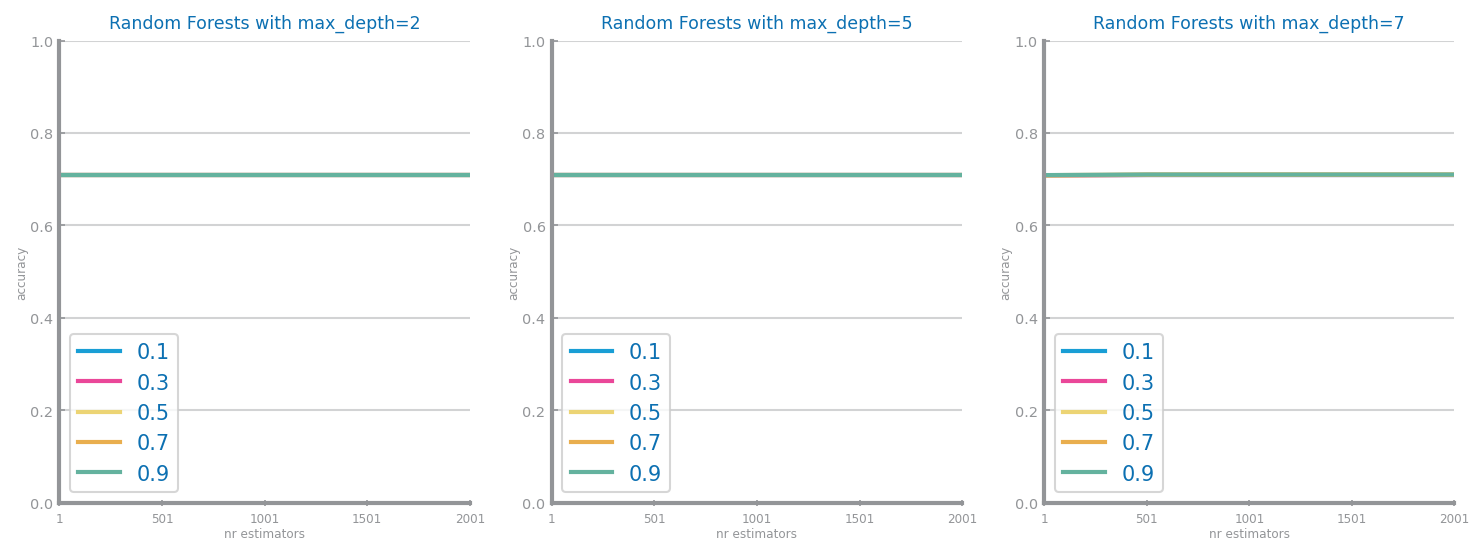

In [7]:
import pandas as pd

results_df = pd.DataFrame(search.cv_results_)
results_df.to_csv("./health_forests_results.csv")

cols: int = len(max_depths)
_, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
for i, max_depth in enumerate(max_depths):
  print(i)
  results = results_df[results_df["param_max_depth"] == max_depth]
  results = results[["param_max_features", "param_n_estimators", "split0_test_score", "split0_train_score"]]

  values = {}
  for max_feature, group in results.groupby("param_max_features"):
    scores = [group[group["param_n_estimators"] == n_estimator]["split0_test_score"].values[0] for n_estimator in n_estimators]
    values[max_feature] = scores

  plot_multiline_chart(
      n_estimators,
      values,
      ax=axs[0, i],
      title=f"Random Forests with max_depth={max_depth}",
      xlabel="nr estimators",
      ylabel="accuracy",
      percentage=True,
  )

best_model = search.best_estimator_
params = {"params": search.best_params_, "metric": "accuracy", "name": "random_forest"}
savefig(f"images/{file_tag}_rf_{eval_metric}_study.png", bbox_inches="tight")
show()

In [ ]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_rf_{params["name"]}_best_{params["metric"]}_eval.png')
show()

In [ ]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

stdevs: list[float] = list(
    std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
)
importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="RF variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_rf_{eval_metric}_vars_ranking.png", bbox_inches="tight")

<h3>Overfitting study</h3>

In [ ]:
d_max: int = params["params"][0]
feat: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "accuracy"

for n in nr_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"RF overfitting study for d={d_max} and f={feat}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_rf_{eval_metric}_overfitting.png")